In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_PATH = '/content/drive/MyDrive/Machine Learning and Pattern Recognition Project'
IMAGES_PATH_1 = DATA_PATH + '/HAM10000_images_part_1'
IMAGES_PATH_2 = DATA_PATH + '/HAM10000_images_part_2'
METADATA_PATH = DATA_PATH + '/HAM10000_metadata.csv'

# 2. Libraries

# 2.1 Load Required Libraries

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from glob import glob

import PIL
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
filterwarnings('ignore')

import tensorflow as tf

tf.get_logger().setLevel('ERROR')

SEED=123
np.random.seed(SEED)

# 3. Configs

In [5]:
CFG = dict(
    batch_size            =  20,   # 8; 16; 32; 64; bigger batch size => moemry allocation issue
    epochs                =  30,   # 5; 10; 20;
    last_trainable_layers =   0,
    verbose               =   1,   # 0; 1
    fontsize              =  14,

    # Images sizes
    img_width             = 150,   # 600 Original
    img_height            = 112,   # 450 Original

    # Images augs
    ROTATION_RANGE        =  90.0,
    ZOOM_RANGE            =   0.1,
    HSHIFT_RANGE          =   0.1,
    WSHIFT_RANGE          =   0.1,
    HFLIP                 = False,
    VFLIP                 = False,

    # Postprocessing
    stopper_patience      =  10,   # 0.01; 0.05; 0.1; 0.2;
    run_functions_eagerly = False
)


# 4. Paths

In [6]:
base_skin_dir = DATA_PATH
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*.jpg'))}

In [7]:
print("First 5 items in imageid_path_dict:")
for i, (image_id, image_path) in enumerate(imageid_path_dict.items()):
    if i < 5:
        print(f"Image ID: {image_id}, Path: {image_path}")
    else:
        break

if not imageid_path_dict:
    print("\nThe imageid_path_dict is empty. No image files were found matching the specified pattern.")
else:
    print("\nSuccessfully created imageid_path_dict with", len(imageid_path_dict), "items.")

First 5 items in imageid_path_dict:
Image ID: ISIC_0033361, Path: /content/drive/MyDrive/Machine Learning and Pattern Recognition Project/HAM10000_images_part_2/ISIC_0033361.jpg
Image ID: ISIC_0033320, Path: /content/drive/MyDrive/Machine Learning and Pattern Recognition Project/HAM10000_images_part_2/ISIC_0033320.jpg
Image ID: ISIC_0033330, Path: /content/drive/MyDrive/Machine Learning and Pattern Recognition Project/HAM10000_images_part_2/ISIC_0033330.jpg
Image ID: ISIC_0033371, Path: /content/drive/MyDrive/Machine Learning and Pattern Recognition Project/HAM10000_images_part_2/ISIC_0033371.jpg
Image ID: ISIC_0033312, Path: /content/drive/MyDrive/Machine Learning and Pattern Recognition Project/HAM10000_images_part_2/ISIC_0033312.jpg

Successfully created imageid_path_dict with 10015 items.


# 5. Dataset
# 5.1 Description

The data set contains the following diseases:  
- Actinic Keratosis
- Basal Cell Carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented Benign Keratosis
- Vascular Lesion

In [8]:
df = pd.read_csv(METADATA_PATH)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
print("Dataset shape:", df.shape)

Dataset shape: (10015, 7)


In [10]:
print("Columns: " + str(list(df.columns)))

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']


In [11]:
print("=== DATASET OVERVIEW ===")
print("Total number of samples: " + str(len(df)))
print("Number of features: " + str(df.shape[1]))
print("\n=== COLUMN INFORMATION ===")
df.info()

=== DATASET OVERVIEW ===
Total number of samples: 10015
Number of features: 7

=== COLUMN INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [12]:
# Lesion types
classes = df.dx.unique()
num_classes = len(classes)
classes, num_classes

(array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object), 7)

In [14]:
df['path'] = df.image_id.map(imageid_path_dict.get)

# 5.2 Exploratory Data Analysis

In [15]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0


In [16]:
df.age.fillna((df.age.mean()), inplace=True)
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0


# 6 Preprocessing

# 6.1 Keras image data processing for Machine Learning Models

In [17]:
df['image'] = df.path.map(lambda x: np.asarray(Image.open(x).resize((CFG['img_width'], CFG['img_height']))))


In [18]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Load & resize image
def load_and_resize_image(path, target_size):
    return np.asarray(Image.open(path).resize(target_size))

# 2. Load images into df['image']
df['image'] = df['path'].map(lambda x: load_and_resize_image(x, (CFG['img_width'], CFG['img_height'])))

# 3. Image preprocessing: convert to float, reverse channels, subtract mean per channel
def prepare_images(images):
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]  # RGB to BGR
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images

# 4. Train-validation-test splitting
trainset, testset = train_test_split(df, test_size=0.2, random_state=80)
trainset, validationset = train_test_split(trainset, test_size=0.2, random_state=600)

In [21]:
# 5. Preprocess images
train_images = prepare_images(list(trainset['image']))
test_images = prepare_images(list(testset['image']))
validation_images = prepare_images(list(validationset['image']))

In [22]:
# 6. Flatten images for ML models
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)
validation_images = validation_images.reshape(validation_images.shape[0], -1)

In [23]:
# 7. Normalize features
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)
validation_images = scaler.transform(validation_images)

In [24]:
from sklearn.decomposition import IncrementalPCA

# 7. Apply Incremental PCA to reduce dimensionality
n_components = 100
batch_size = 100

ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Fit on training data
train_images_pca = ipca.fit_transform(train_images)

# Transform test and validation
test_images_pca = ipca.transform(test_images)
validation_images_pca = ipca.transform(validation_images)

# Optional: check explained variance ratio
print(f"Incremental PCA retained {np.sum(ipca.explained_variance_ratio_):.2%} of total variance")


Incremental PCA retained 94.22% of total variance


In [25]:
# 9. Prepare labels
train_labels = np.asarray(trainset['dx'])
test_labels = np.asarray(testset['dx'])
validation_labels = np.asarray(validationset['dx'])

# 6.2 Preprocessing Tabular Data

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Features and target
features_for_nb = ['age', 'sex', 'localization', 'dx_type']
target_for_nb = 'dx'

# Drop rows with missing values in these columns
df_cleaned = df.dropna(subset=features_for_nb + [target_for_nb]).copy()

# Separate features and target
X_tabular = df_cleaned[features_for_nb]
y_tabular = df_cleaned[target_for_nb]

# One-hot encode categorical columns manually
X_tabular_encoded = pd.get_dummies(X_tabular, columns=['sex', 'localization', 'dx_type'])

# Scale numeric 'age' column
scaler = StandardScaler()
X_tabular_encoded['age'] = scaler.fit_transform(X_tabular_encoded[['age']])

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_tabular)



# Intersect indices to get matching rows for tabular data for train, test, val
train_idx = trainset.index.intersection(df_cleaned.index)
test_idx = testset.index.intersection(df_cleaned.index)
val_idx = validationset.index.intersection(df_cleaned.index)

tabular_features_train = X_tabular_encoded.loc[train_idx].values
tabular_features_test = X_tabular_encoded.loc[test_idx].values
tabular_features_validation = X_tabular_encoded.loc[val_idx].values

train_labels_enc = y_encoded[df_cleaned.index.get_indexer(train_idx)]
test_labels_enc = y_encoded[df_cleaned.index.get_indexer(test_idx)]
validation_labels_enc = y_encoded[df_cleaned.index.get_indexer(val_idx)]


print("tabular_features_train shape:", tabular_features_train.shape)
print("tabular_features_test shape:", tabular_features_test.shape)
print("tabular_features_validation shape:", tabular_features_validation.shape)

print("train_labels_enc shape:", train_labels_enc.shape)
print("test_labels_enc shape:", test_labels_enc.shape)
print("validation_labels_enc shape:", validation_labels_enc.shape)


tabular_features_train shape: (6409, 23)
tabular_features_test shape: (2003, 23)
tabular_features_validation shape: (1603, 23)
train_labels_enc shape: (6409,)
test_labels_enc shape: (2003,)
validation_labels_enc shape: (1603,)


# 6.3 Combining Tabular and Image Features

In [61]:
# Convert to dense if sparse
tabular_features_train = tabular_features_train.toarray() if hasattr(tabular_features_train, 'toarray') else tabular_features_train
tabular_features_test = tabular_features_test.toarray() if hasattr(tabular_features_test, 'toarray') else tabular_features_test
tabular_features_validation = tabular_features_validation.toarray() if hasattr(tabular_features_validation, 'toarray') else tabular_features_validation


In [62]:

print("train_images_pca shape:", train_images_pca.shape)  # should be (6409, 100)
print("test_images_pca shape:", test_images_pca.shape)    # should be (2003, 100)
print("validation_images_pca shape:", validation_images_pca.shape)  # (1603, 100)

# Combine features horizontally (concatenate columns)
train_combined = np.hstack([train_images_pca, tabular_features_train])
test_combined = np.hstack([test_images_pca, tabular_features_test])
validation_combined = np.hstack([validation_images_pca, tabular_features_validation])

print("train_combined shape:", train_combined.shape)  # (6409, 123)
print("test_combined shape:", test_combined.shape)    # (2003, 123)
print("validation_combined shape:", validation_combined.shape)  # (1603, 123)


train_images_pca shape: (6409, 100)
test_images_pca shape: (2003, 100)
validation_images_pca shape: (1603, 100)
train_combined shape: (6409, 123)
test_combined shape: (2003, 123)
validation_combined shape: (1603, 123)


# 7. Model

# 7.1 Build the Models

Naive Bayes

In [63]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Gaussian Naive Bayes model
naive_bayes_model = GaussianNB()

# Train the model on the combined training data
print("Training Naive Bayes model...")
naive_bayes_model.fit(train_combined, train_labels_enc)
print("Training complete.")

# Predict on the validation set
print("Predicting on validation set...")
validation_predictions = naive_bayes_model.predict(validation_combined)

# Evaluate the model on the validation set
print("\nEvaluating Naive Bayes model on validation set:")
accuracy = accuracy_score(validation_labels_enc, validation_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

# Get the original class names using the label encoder
original_class_names = label_encoder.inverse_transform(np.unique(y_encoded))

# Print classification report
print("\nClassification Report (Validation Set):")
print(classification_report(validation_labels_enc, validation_predictions, target_names=original_class_names))

# Print confusion matrix
print("\nConfusion Matrix (Validation Set):")
conf_matrix = confusion_matrix(validation_labels_enc, validation_predictions)
print(conf_matrix)


print("\nPredicting on test set...")
test_predictions = naive_bayes_model.predict(test_combined)

# Evaluate the model on the test set
print("\nEvaluating Naive Bayes model on test set:")
accuracy_test = accuracy_score(test_labels_enc, test_predictions)
print(f"Test Accuracy: {accuracy_test:.4f}")

# Print classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(test_labels_enc, test_predictions, target_names=original_class_names))

# Print confusion matrix for the test set
print("\nConfusion Matrix (Test Set):")
conf_matrix_test = confusion_matrix(test_labels_enc, test_predictions)
conf_matrix_test



Training Naive Bayes model...
Training complete.
Predicting on validation set...

Evaluating Naive Bayes model on validation set:
Validation Accuracy: 0.4997

Classification Report (Validation Set):
              precision    recall  f1-score   support

       akiec       0.18      0.53      0.26        57
         bcc       0.15      0.42      0.22        72
         bkl       0.59      0.13      0.22       164
          df       0.05      0.81      0.09        16
         mel       0.38      0.38      0.38       194
          nv       0.99      0.58      0.73      1075
        vasc       0.11      0.44      0.18        25

    accuracy                           0.50      1603
   macro avg       0.35      0.47      0.30      1603
weighted avg       0.79      0.50      0.58      1603


Confusion Matrix (Validation Set):
[[ 30   7   0  11   9   0   0]
 [ 20  30   0  15   4   1   2]
 [ 35  25  22  30  19   3  30]
 [  0   2   0  13   1   0   0]
 [ 49  28   0  41  74   1   1]
 [ 36 110  15

array([[ 32,  11,   0,  12,  11,   0,   1],
       [ 28,  43,   0,  18,  10,   2,   3],
       [ 59,  34,  23,  52,  26,   5,  25],
       [  2,   0,   1,  19,   3,   1,   0],
       [ 46,  29,   1,  42,  86,   3,   3],
       [ 35, 131,  24, 196, 112, 784,  68],
       [  1,   1,   1,   7,   4,   0,   8]])

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import IncrementalPCA

# Ensure labels are encoded numerically for Naive Bayes
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)

naive_bayes_image_model = GaussianNB()

# Train the model using only the image features
print("Training Naive Bayes model using only image features...")
naive_bayes_image_model.fit(train_images_pca, train_labels_encoded)
print("Training complete.")

# Predict on the validation set using only image features
print("Predicting on validation set using only image features...")
validation_predictions_image = naive_bayes_image_model.predict(validation_images_pca)

# Evaluate the model on the validation set
print("\nEvaluating Naive Bayes model on validation set (Image Features Only):")
accuracy_image_val = accuracy_score(validation_labels_encoded, validation_predictions_image)
print(f"Validation Accuracy (Image Only): {accuracy_image_val:.4f}")

# Get the original class names using the label encoder
original_class_names = label_encoder.classes_

# Print classification report for validation set (Image Only)
print("\nClassification Report (Validation Set - Image Only):")
print(classification_report(validation_labels_encoded, validation_predictions_image, target_names=original_class_names))

# Print confusion matrix for validation set (Image Only)
print("\nConfusion Matrix (Validation Set - Image Only):")
conf_matrix_image_val = confusion_matrix(validation_labels_encoded, validation_predictions_image)
print(conf_matrix_image_val)


# Test set after final model selection (Image Only)
print("\nPredicting on test set using only image features...")
test_predictions_image = naive_bayes_image_model.predict(test_images_pca)

# Evaluate the model on the test set
print("\nEvaluating Naive Bayes model on test set (Image Features Only):")
accuracy_image_test = accuracy_score(test_labels_encoded, test_predictions_image)
print(f"Test Accuracy (Image Only): {accuracy_image_test:.4f}")

# Print classification report for the test set (Image Only)
print("\nClassification Report (Test Set - Image Only):")
print(classification_report(test_labels_encoded, test_predictions_image, target_names=original_class_names))

# Print confusion matrix for the test set (Image Only)
print("\nConfusion Matrix (Test Set - Image Only):")
conf_matrix_image_test = confusion_matrix(test_labels_encoded, test_predictions_image)
conf_matrix_image_test


In [ ]:
# Initialize the Gaussian Naive Bayes model for tabular data
naive_bayes_tabular_model = GaussianNB()

# Train the model using only the tabular features
print("Training Naive Bayes model using only tabular features...")
naive_bayes_tabular_model.fit(tabular_features_train, train_labels_enc)
print("Training complete.")

# Predict on the validation set using only tabular features
print("Predicting on validation set using only tabular features...")
validation_predictions_tabular = naive_bayes_tabular_model.predict(tabular_features_validation)

# Evaluate the model on the validation set
print("\nEvaluating Naive Bayes model on validation set (Tabular Features Only):")
accuracy_tabular_val = accuracy_score(validation_labels_enc, validation_predictions_tabular)
print(f"Validation Accuracy (Tabular Only): {accuracy_tabular_val:.4f}")

# Get the original class names using the label encoder
original_class_names = label_encoder.classes_

# Print classification report for validation set (Tabular Only)
print("\nClassification Report (Validation Set - Tabular Only):")
print(classification_report(validation_labels_enc, validation_predictions_tabular, target_names=original_class_names))

# Print confusion matrix for validation set (Tabular Only)
print("\nConfusion Matrix (Validation Set - Tabular Only):")
conf_matrix_tabular_val = confusion_matrix(validation_labels_enc, validation_predictions_tabular)
print(conf_matrix_tabular_val)


# Evaluate on the test set after final model selection (Tabular Only)
print("\nPredicting on test set using only tabular features...")
test_predictions_tabular = naive_bayes_tabular_model.predict(tabular_features_test)

# Evaluate the model on the test set
print("\nEvaluating Naive Bayes model on test set (Tabular Features Only):")
accuracy_tabular_test = accuracy_score(test_labels_enc, test_predictions_tabular)
print(f"Test Accuracy (Tabular Only): {accuracy_tabular_test:.4f}")

# Print classification report for the test set (Tabular Only)
print("\nClassification Report (Test Set - Tabular Only):")
print(classification_report(test_labels_enc, test_predictions_tabular, target_names=original_class_names))

# Print confusion matrix for the test set (Tabular Only)
print("\nConfusion Matrix (Test Set - Tabular Only):")
conf_matrix_tabular_test = confusion_matrix(test_labels_enc, test_predictions_tabular)
conf_matrix_tabular_test


KNN

In [80]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Copy tabular features (to avoid interfering with other models)
tab_train_for_knn = tabular_features_train.copy()
tab_val_for_knn = tabular_features_validation.copy()
tab_test_for_knn = tabular_features_test.copy()

# Scale tabular features (for KNN only)
scaler_knn = StandardScaler()
tab_train_for_knn = scaler_knn.fit_transform(tab_train_for_knn)
tab_val_for_knn = scaler_knn.transform(tab_val_for_knn)
tab_test_for_knn = scaler_knn.transform(tab_test_for_knn)

# Combine scaled tabular + image features
train_combined_knn = np.hstack([train_images_pca, tab_train_for_knn])
validation_combined_knn = np.hstack([validation_images_pca, tab_val_for_knn])
test_combined_knn = np.hstack([test_images_pca, tab_test_for_knn])

# Initialize and train KNN
knn_model = KNeighborsClassifier(n_neighbors=10)
print(" Training KNN on combined features...")
knn_model.fit(train_combined_knn, train_labels_enc)
print("Training complete.")

#  Validation evaluation
print("\n Predicting on validation set...")
val_preds_knn = knn_model.predict(validation_combined_knn)

print("\ KNN Validation Accuracy:", accuracy_score(validation_labels_enc, val_preds_knn))
print("\nClassification Report (Validation):")
print(classification_report(validation_labels_enc, val_preds_knn, target_names=original_class_names))
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(validation_labels_enc, val_preds_knn))

# Test evaluation
print("\n Predicting on test set...")
test_preds_knn = knn_model.predict(test_combined_knn)

print("\ KNN Test Accuracy:", accuracy_score(test_labels_enc, test_preds_knn))
print("\nClassification Report (Test):")
print(classification_report(test_labels_enc, test_preds_knn, target_names=original_class_names))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(test_labels_enc, test_preds_knn))

accuracy_knn_combined_test = accuracy_score(test_labels_enc, test_preds_knn)


📌 Training KNN on combined features...
✅ Training complete.

🔎 Predicting on validation set...

📊 KNN Validation Accuracy: 0.6887086712414223

Classification Report (Validation):
              precision    recall  f1-score   support

       akiec       0.58      0.12      0.20        57
         bcc       0.35      0.32      0.33        72
         bkl       0.28      0.27      0.28       164
          df       0.00      0.00      0.00        16
         mel       0.45      0.08      0.13       194
          nv       0.76      0.94      0.84      1075
        vasc       0.00      0.00      0.00        25

    accuracy                           0.69      1603
   macro avg       0.35      0.25      0.26      1603
weighted avg       0.63      0.69      0.63      1603


Confusion Matrix (Validation):
[[   7   14   17    0    0   19    0]
 [   0   23   11    0    1   37    0]
 [   4    9   45    0    4  102    0]
 [   0    1    6    0    0    9    0]
 [   0    6   42    0   15  131    0]
 [

In [ ]:
# KNN for Image Data Only


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn_image_model = KNeighborsClassifier(n_neighbors=10)

# Train the model using only the image features
print("Training KNN model using only image features...")
knn_image_model.fit(train_images_pca, train_labels_encoded)
print("Training complete.")

# Predict on the validation set using only image features
print("Predicting on validation set using only image features...")
validation_predictions_knn_image = knn_image_model.predict(validation_images_pca)

# Evaluate the model on the validation set
print("\nEvaluating KNN model on validation set (Image Features Only):")
accuracy_knn_image_val = accuracy_score(validation_labels_encoded, validation_predictions_knn_image)
print(f"Validation Accuracy (Image Only): {accuracy_knn_image_val:.4f}")


# Print classification report for validation set (Image Only)
print("\nClassification Report (Validation Set - KNN - Image Only):")
print(classification_report(validation_labels_encoded, validation_predictions_knn_image, target_names=original_class_names))

# Print confusion matrix for validation set (Image Only)
print("\nConfusion Matrix (Validation Set - KNN - Image Only):")
conf_matrix_knn_image_val = confusion_matrix(validation_labels_encoded, validation_predictions_knn_image)
print(conf_matrix_knn_image_val)


# Evaluate on the test set after final model selection (Image Only)
print("\nPredicting on test set using only image features...")
test_predictions_knn_image = knn_image_model.predict(test_images_pca)

# Evaluate the model on the test set
print("\nEvaluating KNN model on test set (Image Features Only):")
accuracy_knn_image_test = accuracy_score(test_labels_encoded, test_predictions_knn_image)
print(f"Test Accuracy (Image Only): {accuracy_knn_image_test:.4f}")

# Print classification report for the test set (Image Only)
print("\nClassification Report (Test Set - KNN - Image Only):")
print(classification_report(test_labels_encoded, test_predictions_knn_image, target_names=original_class_names))

# Print confusion matrix for the test set (Image Only)
print("\nConfusion Matrix (Test Set - KNN - Image Only):")
conf_matrix_knn_image_test = confusion_matrix(test_labels_encoded, test_predictions_knn_image)
conf_matrix_knn_image_test


In [ ]:

# KNN for Tabular Data Only

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import IncrementalPCA


knn_tabular_model = KNeighborsClassifier(n_neighbors=10)

# Train the model using only the tabular features
print("Training KNN model using only tabular features...")
knn_tabular_model.fit(tabular_features_train, train_labels_enc)
print("Training complete.")

# Predict on the validation set using only tabular features
print("Predicting on validation set using only tabular features...")
validation_predictions_knn_tabular = knn_tabular_model.predict(tabular_features_validation)

# Evaluate the model on the validation set
print("\nEvaluating KNN model on validation set (Tabular Features Only):")
accuracy_knn_tabular_val = accuracy_score(validation_labels_enc, validation_predictions_knn_tabular)
print(f"Validation Accuracy (Tabular Only): {accuracy_knn_tabular_val:.4f}")

# Get the original class names using the label encoder
original_class_names = label_encoder.classes_

# Print classification report for validation set (Tabular Only)
print("\nClassification Report (Validation Set - KNN - Tabular Only):")
print(classification_report(validation_labels_enc, validation_predictions_knn_tabular, target_names=original_class_names))

# Print confusion matrix for validation set (Tabular Only)
print("\nConfusion Matrix (Validation Set - KNN - Tabular Only):")
conf_matrix_knn_tabular_val = confusion_matrix(validation_labels_enc, validation_predictions_knn_tabular)
print(conf_matrix_knn_tabular_val)


# Evaluate on the test set after final model selection (Tabular Only)
print("\nPredicting on test set using only tabular features...")
test_predictions_knn_tabular = knn_tabular_model.predict(tabular_features_test) # Assuming test_features_tabular is available

# Evaluate the model on the test set
print("\nEvaluating KNN model on test set (Tabular Features Only):")
accuracy_knn_tabular_test = accuracy_score(test_labels_enc, test_predictions_knn_tabular) # Assuming test_labels_enc is available
print(f"Test Accuracy (Tabular Only): {accuracy_knn_tabular_test:.4f}")

# Print classification report for the test set (Tabular Only)
print("\nClassification Report (Test Set - KNN - Tabular Only):")
print(classification_report(test_labels_enc, test_predictions_knn_tabular, target_names=original_class_names))

# Print confusion matrix for the test set (Tabular Only)
print("\nConfusion Matrix (Test Set - KNN - Tabular Only):")
conf_matrix_knn_tabular_test = confusion_matrix(test_labels_enc, test_predictions_knn_tabular)
conf_matrix_knn_tabular_test


Decision Tree

In [37]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


decision_tree_model = DecisionTreeClassifier(random_state=SEED)

# Train the model on the combined training data
print("Training Decision Tree model...")
decision_tree_model.fit(train_combined, train_labels_enc)
print("Training complete.")

# Predict on the validation set
print("Predicting on validation set...")
validation_predictions_dt = decision_tree_model.predict(validation_combined)

# Evaluate the model on the validation set
print("\nEvaluating Decision Tree model on validation set:")
accuracy_dt = accuracy_score(validation_labels_enc, validation_predictions_dt)
print(f"Validation Accuracy: {accuracy_dt:.4f}")


# Print classification report
print("\nClassification Report (Validation Set - Decision Tree):")
print(classification_report(validation_labels_enc, validation_predictions_dt, target_names=original_class_names))

# Print confusion matrix
print("\nConfusion Matrix (Validation Set - Decision Tree):")
conf_matrix_dt = confusion_matrix(validation_labels_enc, validation_predictions_dt)
print(conf_matrix_dt)


# Evaluate on the test set after final model selection
print("\nPredicting on test set...")
test_predictions_dt = decision_tree_model.predict(test_combined)

# Evaluate the model on the test set
print("\nEvaluating Decision Tree model on test set:")
accuracy_test_dt = accuracy_score(test_labels_enc, test_predictions_dt)
print(f"Test Accuracy: {accuracy_test_dt:.4f}")

# Print classification report for the test set
print("\nClassification Report (Test Set - Decision Tree):")
print(classification_report(test_labels_enc, test_predictions_dt, target_names=original_class_names))

# Print confusion matrix for the test set
print("\nConfusion Matrix (Test Set - Decision Tree):")
conf_matrix_test_dt = confusion_matrix(test_labels_enc, test_predictions_dt)
conf_matrix_test_dt

Training Decision Tree model...
Training complete.
Predicting on validation set...

Evaluating Decision Tree model on validation set:
Validation Accuracy: 0.6744

Classification Report (Validation Set - Decision Tree):
              precision    recall  f1-score   support

       akiec       0.23      0.23      0.23        57
         bcc       0.29      0.28      0.29        72
         bkl       0.41      0.46      0.43       164
          df       0.12      0.19      0.14        16
         mel       0.32      0.28      0.30       194
          nv       0.85      0.85      0.85      1075
        vasc       0.22      0.28      0.25        25

    accuracy                           0.67      1603
   macro avg       0.35      0.36      0.35      1603
weighted avg       0.68      0.67      0.68      1603


Confusion Matrix (Validation Set - Decision Tree):
[[ 13  12  13   2   3  13   1]
 [ 11  20  11   3   6  19   2]
 [  7   8  75   4  22  43   5]
 [  0   2   6   3   0   4   1]
 [ 16   

array([[  18,   15,   12,    3,    5,   14,    0],
       [  14,   27,   25,    6,   14,   17,    1],
       [  13,    7,   94,    3,   46,   56,    5],
       [   5,    2,    4,    3,    5,    7,    0],
       [  12,   19,   32,    4,   66,   74,    3],
       [  18,   19,   61,   13,   87, 1142,   10],
       [   0,    1,    4,    0,    2,    9,    6]])

In [ ]:
# Image features

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



decision_tree_image_model = DecisionTreeClassifier(random_state=SEED)

# Train the model using only the image features
print("Training Decision Tree model using only image features...")
decision_tree_image_model.fit(train_images_pca, train_labels_encoded)
print("Training complete.")

# Predict on the validation set using only image features
print("Predicting on validation set using only image features...")
validation_predictions_dt_image = decision_tree_image_model.predict(validation_images_pca)

# Evaluate the model on the validation set
print("\nEvaluating Decision Tree model on validation set (Image Features Only):")
accuracy_dt_image_val = accuracy_score(validation_labels_encoded, validation_predictions_dt_image)
print(f"Validation Accuracy (Image Only): {accuracy_dt_image_val:.4f}")


# Print classification report for validation set (Image Only)
print("\nClassification Report (Validation Set - Decision Tree - Image Only):")
print(classification_report(validation_labels_encoded, validation_predictions_dt_image, target_names=original_class_names))

# Print confusion matrix for validation set (Image Only)
print("\nConfusion Matrix (Validation Set - Decision Tree - Image Only):")
conf_matrix_dt_image_val = confusion_matrix(validation_labels_encoded, validation_predictions_dt_image)
print(conf_matrix_dt_image_val)


# Evaluate on the test set after final model selection (Image Only)
print("\nPredicting on test set using only image features...")
test_predictions_dt_image = decision_tree_image_model.predict(test_images_pca)

# Evaluate the model on the test set
print("\nEvaluating Decision Tree model on test set (Image Features Only):")
accuracy_dt_image_test = accuracy_score(test_labels_encoded, test_predictions_dt_image)
print(f"Test Accuracy (Image Only): {accuracy_dt_image_test:.4f}")

# Print classification report for the test set (Image Only)
print("\nClassification Report (Test Set - Decision Tree - Image Only):")
print(classification_report(test_labels_encoded, test_predictions_dt_image, target_names=original_class_names))

# Print confusion matrix for the test set (Image Only)
print("\nConfusion Matrix (Test Set - Decision Tree - Image Only):")
conf_matrix_dt_image_test = confusion_matrix(test_labels_encoded, test_predictions_dt_image)
conf_matrix_dt_image_test


In [57]:
# Decision Tree for Tabular Data Only

decision_tree_tabular_model = DecisionTreeClassifier(random_state=SEED)

# Train the model using only the tabular features
print("Training Decision Tree model using only tabular features...")
decision_tree_tabular_model.fit(tabular_features_train, train_labels_enc)
print("Training complete.")

# Predict on the validation set using only tabular features
print("Predicting on validation set using only tabular features...")
validation_predictions_dt_tabular = decision_tree_tabular_model.predict(tabular_features_validation)

# Evaluate the model on the validation set
print("\nEvaluating Decision Tree model on validation set (Tabular Features Only):")
accuracy_dt_tabular_val = accuracy_score(validation_labels_enc, validation_predictions_dt_tabular)
print(f"Validation Accuracy (Tabular Only): {accuracy_dt_tabular_val:.4f}")

# Get the original class names using the label encoder
original_class_names = label_encoder.classes_

# Print classification report for validation set (Tabular Only)
print("\nClassification Report (Validation Set - Decision Tree - Tabular Only):")
print(classification_report(validation_labels_enc, validation_predictions_dt_tabular, target_names=original_class_names))

# Print confusion matrix for validation set (Tabular Only)
print("\nConfusion Matrix (Validation Set - Decision Tree - Tabular Only):")
conf_matrix_dt_tabular_val = confusion_matrix(validation_labels_enc, validation_predictions_dt_tabular)
print(conf_matrix_dt_tabular_val)


# Evaluate on the test set after final model selection (Tabular Only)
print("\nPredicting on test set using only tabular features...")
test_predictions_dt_tabular = decision_tree_tabular_model.predict(tabular_features_test)

# Evaluate the model on the test set
print("\nEvaluating Decision Tree model on test set (Tabular Features Only):")
accuracy_dt_tabular_test = accuracy_score(test_labels_enc, test_predictions_dt_tabular)
print(f"Test Accuracy (Tabular Only): {accuracy_dt_tabular_test:.4f}")

# Print classification report for the test set (Tabular Only)
print("\nClassification Report (Test Set - Decision Tree - Tabular Only):")
print(classification_report(test_labels_enc, test_predictions_dt_tabular, target_names=original_class_names))

# Print confusion matrix for the test set (Tabular Only)
print("\nConfusion Matrix (Test Set - Decision Tree - Tabular Only):")
conf_matrix_dt_tabular_test = confusion_matrix(test_labels_enc, test_predictions_dt_tabular)
conf_matrix_dt_tabular_test


Training Decision Tree model using only tabular features...
Training complete.
Predicting on validation set using only tabular features...

Evaluating Decision Tree model on validation set (Tabular Features Only):
Validation Accuracy (Tabular Only): 0.7193

Classification Report (Validation Set - Decision Tree - Tabular Only):
              precision    recall  f1-score   support

       akiec       0.43      0.16      0.23        57
         bcc       0.33      0.22      0.26        72
         bkl       0.42      0.47      0.44       164
          df       0.50      0.19      0.27        16
         mel       0.38      0.31      0.34       194
          nv       0.84      0.92      0.88      1075
        vasc       0.29      0.16      0.21        25

    accuracy                           0.72      1603
   macro avg       0.45      0.35      0.38      1603
weighted avg       0.69      0.72      0.70      1603


Confusion Matrix (Validation Set - Decision Tree - Tabular Only):
[[  9  

array([[   6,   10,   17,    0,   15,   19,    0],
       [   3,   20,   23,    0,   24,   34,    0],
       [   8,   16,  100,    5,   37,   57,    1],
       [   0,    0,    2,    7,    3,   14,    0],
       [   3,   16,   37,    0,   60,   93,    1],
       [   1,    9,   32,    3,   51, 1252,    2],
       [   0,    1,    6,    0,    1,    9,    5]])

Comparison

Test Set Accuracies:
                Tabular     Image  Combined
Naive Bayes    0.425362  0.515726  0.496755
KNN            0.701448  0.705941  0.707439
Decision Tree  0.723914  0.597104  0.676985


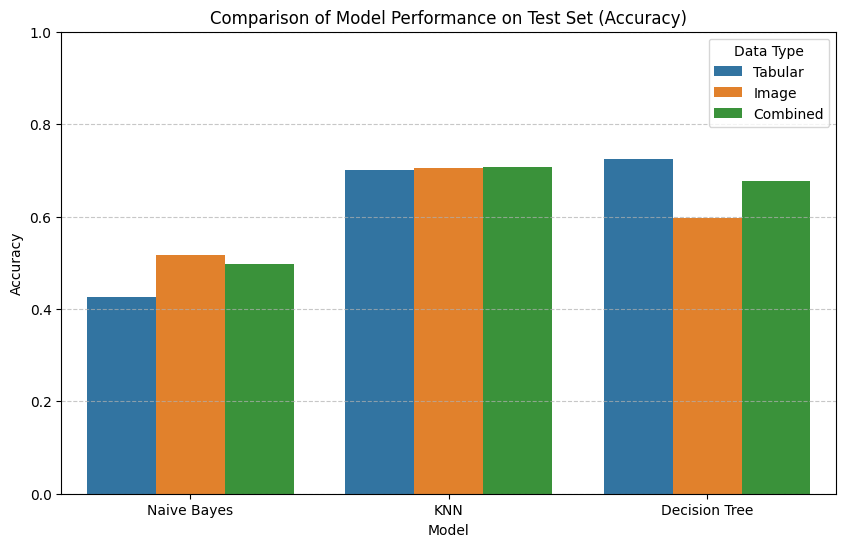

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

model_names = ['Naive Bayes', 'KNN', 'Decision Tree']
data_types = ['Tabular', 'Image', 'Combined']

accuracies = {
    'Tabular': [accuracy_tabular_test, accuracy_knn_tabular_test, accuracy_dt_tabular_test],
    'Image': [accuracy_image_test, accuracy_knn_image_test, accuracy_dt_image_test],
    'Combined': [accuracy_test, accuracy_knn_combined_test, accuracy_test_dt]
}

accuracy_df = pd.DataFrame(accuracies, index=model_names)

print("Test Set Accuracies:")
print(accuracy_df)

accuracy_melted = accuracy_df.reset_index().melt('index', var_name='Data Type', value_name='Accuracy')
accuracy_melted = accuracy_melted.rename(columns={'index': 'Model'})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Data Type', data=accuracy_melted)
plt.title('Comparison of Model Performance on Test Set (Accuracy)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Extra Models

Bonus Model
XGBOOST

In [ ]:

import numpy as np

!pip install xgboost

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

num_classes_encoded = len(np.unique(train_labels_enc))

xgb_model = xgb.XGBClassifier(objective='multi:softmax',
                              num_class=num_classes_encoded,
                              eval_metric='merror',
                              use_label_encoder=False,
                              random_state=SEED)

# Train the model on the combined training data
print("Training XGBoost model...")

xgb_model.fit(train_combined, train_labels_enc,
              eval_set=[(validation_combined, validation_labels_enc)],
              verbose=False)

print("Training complete.")

# Predict on the validation set
print("Predicting on validation set...")
validation_predictions_xgb = xgb_model.predict(validation_combined)

# Evaluate the model on the validation set
print("\nEvaluating XGBoost model on validation set:")
accuracy_xgb = accuracy_score(validation_labels_enc, validation_predictions_xgb)
print(f"Validation Accuracy: {accuracy_xgb:.4f}")

# Print classification report
print("\nClassification Report (Validation Set - XGBoost):")
print(classification_report(validation_labels_enc, validation_predictions_xgb, target_names=original_class_names))

# Print confusion matrix
print("\nConfusion Matrix (Validation Set - XGBoost):")
conf_matrix_xgb = confusion_matrix(validation_labels_enc, validation_predictions_xgb)
print(conf_matrix_xgb)


# Evaluate on the test set after final model selection
print("\nPredicting on test set...")
test_predictions_xgb = xgb_model.predict(test_combined)

# Evaluate the model on the test set
print("\nEvaluating XGBoost model on test set:")
accuracy_test_xgb = accuracy_score(test_labels_enc, test_predictions_xgb)
print(f"Test Accuracy: {accuracy_test_xgb:.4f}")

# Print classification report for the test set
print("\nClassification Report (Test Set - XGBoost):")
print(classification_report(test_labels_enc, test_predictions_xgb, target_names=original_class_names))

# Print confusion matrix for the test set
print("\nConfusion Matrix (Test Set - XGBoost):")
conf_matrix_test_xgb = confusion_matrix(test_labels_enc, test_predictions_xgb)
conf_matrix_test_xgb


Training XGBoost model...
Training complete.
Predicting on validation set...

Evaluating XGBoost model on validation set:
Validation Accuracy: 0.7848

Classification Report (Validation Set - XGBoost):
              precision    recall  f1-score   support

       akiec       0.54      0.26      0.35        57
         bcc       0.46      0.39      0.42        72
         bkl       0.58      0.54      0.56       164
          df       1.00      0.19      0.32        16
         mel       0.55      0.45      0.50       194
          nv       0.86      0.96      0.91      1075
        vasc       1.00      0.36      0.53        25

    accuracy                           0.78      1603
   macro avg       0.71      0.45      0.51      1603
weighted avg       0.77      0.78      0.77      1603


Confusion Matrix (Validation Set - XGBoost):
[[  15   14   14    0    7    7    0]
 [   7   28   12    0    9   16    0]
 [   3    4   88    0   19   50    0]
 [   0    5    1    3    0    7    0]
 [  

array([[  17,   13,   11,    0,   13,   13,    0],
       [   6,   51,   21,    0,    7,   18,    1],
       [   6,    6,  117,    2,   25,   68,    0],
       [   3,    3,    3,    6,    3,    8,    0],
       [   7,    2,   22,    0,   91,   88,    0],
       [   2,    3,   20,    0,   33, 1291,    1],
       [   0,    1,    3,    1,    0,    9,    8]])